<a href="https://colab.research.google.com/github/ThrishapriyaSelvaraj/cs666student/blob/main/Copy_of_CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

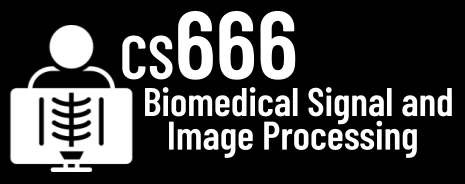
#Assignment 4

In [ ]:
# NAME: THRISHAPRIYA SELVARAJ

In [ ]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [3]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [ ]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [4]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [5]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [ ]:
# TODO: Please display this image and print the dimensions!

In [16]:
img

array([[ 22,  24,  24, ...,  96,  94,  93],
       [ 23,  24,  24, ...,  97,  94,  92],
       [ 24,  24,  23, ...,  99,  96,  94],
       ...,
       [ 49,  50,  48, ..., 119, 119, 119],
       [ 50,  52,  53, ..., 123, 124, 123],
       [ 52,  53,  54, ..., 129, 128, 127]], dtype=uint8)

In [ ]:
# TODO: YOUR CODE

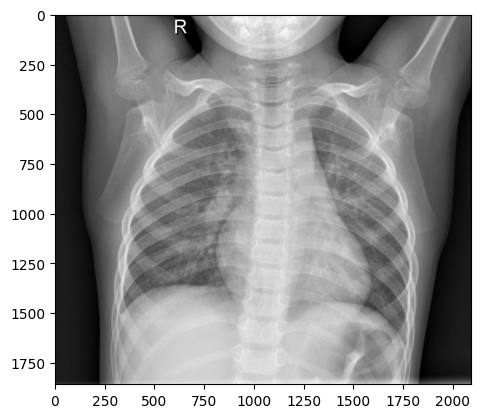

Image dimensions:  (1858, 2090)


In [6]:
#Displaying the image.
plt.imshow(img, cmap='gray')
plt.show()

#Printing the dimensions.
print("Image dimensions: ", img.shape)

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [9]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [33]:
data[0].shape

(100, 300, 300)

In [ ]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) Reading the image files and storing them - mh.imread
# TODO: Operation 2) Converting colored images to greyscale  - mh.colors
# TODO: Operation 3) Resizing images to a standard size and then  storing them in 'data' - mh.imresize

In [ ]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

In [13]:
# TODO: YOUR CODE 


In [ ]:
data


In [44]:
#normal_images=[]
#for d in (0,5):
  #normal_images.append(data[0][d])
# normal_images

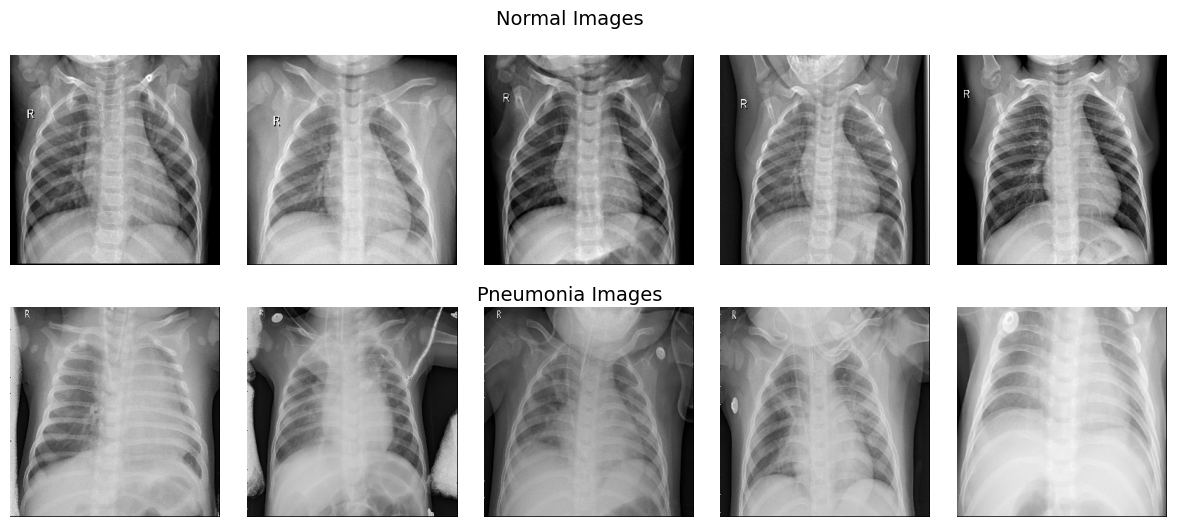

In [68]:
normal_images=[]
pneumonia_images =[]

for d in range(0,5):
  normal_images.append(data[0][d])
  pneumonia_images.append(data[1][d])

# normal_images
fig, axs = plt.subplots(2, len(normal_images), figsize=(15, 6))
for i in range(len(normal_images)):
    axs[0, i].imshow(normal_images[i], cmap='gray')
    axs[0, i].axis('off')

# pneumonia_images
for i in range(len(pneumonia_images)):
    axs[1, i].imshow(pneumonia_images[i], cmap='gray')
    axs[1, i].axis('off')

# Spacing and Font    
   
fig.text(0.5, 0.93, 'Normal Images', ha='center', fontsize=14)
fig.text(0.5, 0.47, 'Pneumonia Images', ha='center', fontsize=14)

for ax in axs.flat:
    ax.set_title('', fontsize=10)
fig.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [ ]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [63]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [69]:
X_train[1].shape

(90000,)

In [70]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
# TODO

# Using np.repeat() function to repeat elements of an array for a given number of times.

y_train = np.repeat([0, 1, 2], 60)

In [71]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [77]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [ ]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
# TODO

In [78]:
# Using np.repeat() function to repeat elements of an array for a given number of times.
y_test = np.repeat([0, 1, 2], 40)

In [79]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [80]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [81]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [82]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [ ]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [ ]:
# TODO: YOUR ANSWER

Random Forest is a classifier that contains several decision trees on various subsets of a given dataset and takes the average to enhance the predicted accuracy of that dataset. As stated above it doesn't rely on a single decision tree, the random forest collects the result from each tree and expects the final output to be based on the majority votes of the predictions.

The steps are explained below: 
Step 1- Pick "M" data points randomly from the training set.
Step 2- Create decision trees for the chosen data points i.e. the subsets.
Step 3- Respective decision tree will produce a result and then analyze it.
Step 4- For classification and regression, the final output is generally taken by considering the majority or else averaging.

In [83]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [ ]:
# TODO: YOUR ANSWER

Yes, the accuracy score is 100% and is perfect.
 No, I wasn't surprised. The result was as expected.

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [ ]:
# TODO: YOUR CODE AND YOUR ANSWER

In [108]:
unseen_images = 99

X_test_covid_only = np.zeros( (unseen_images, 300*300 ), dtype=np.float32)
t_pos = 0

for image in data[2][100:]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test_covid_only[t_pos] = image
    t_pos += 1

In [112]:
 len(data[2][100:])

99

In [113]:
len(X_test_covid_only)

99

In [114]:
y_test_covid_only = (np.full((99,), 2))
y_test_covid_only

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

In [ ]:
# TODO: YOUR CODE AND YOUR ANSWER

In [115]:
predictions = clf.predict(X_test_covid_only)
len(predictions)

99

In [116]:
clf.score( X_test_covid_only, y_test_covid_only )

0.9797979797979798

In [117]:
predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Here, some of the Pneumonia Images have been mistakenly added to the Covid Images array. So, in the above array we can identify two '1' i.e, Pneumonia Images, while rest all are '2' i.e for Covid Images.

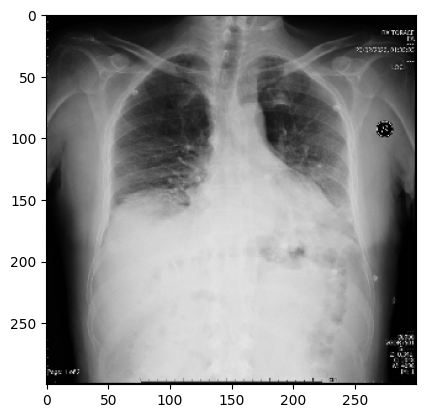

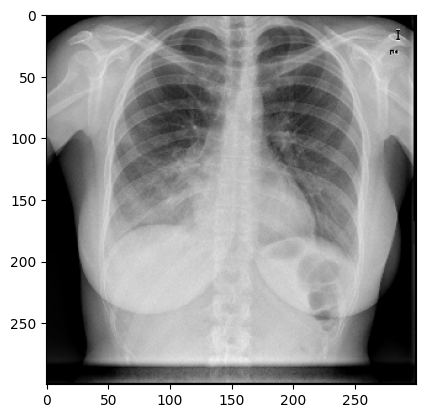

In [119]:
wrong_images = X_test_covid_only[predictions!= 2]
for i in wrong_images:
    plt.imshow(i.reshape(300,300), cmap='gray')
    plt.show()

In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw